# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [11]:
# import libraries
import sqlite3
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold

from joblib import parallel_backend

In [10]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# load data from database
conn = sqlite3.connect('disaster-messages.db')
df = pd.read_sql('SELECT * FROM messages', conn).drop('id', axis=1)
x = df['message']
Y = df.drop(['message', 'original', 'genre'], axis=1)

In [3]:
df.head()

,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

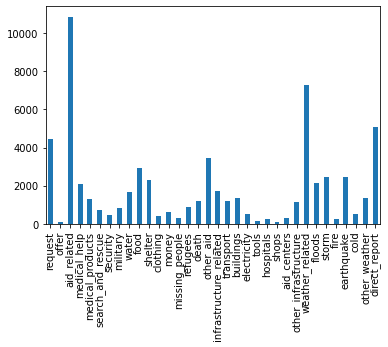

In [4]:
Y.sum().plot(kind='bar')

### 2. Write a tokenization function to process your text data

In [5]:
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from collections import defaultdict

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monikakubek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/monikakubek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/monikakubek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/monikakubek/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/monikakubek/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [7]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [8]:
# sources: 
# https://stackoverflow.com/posts/57686805/revisions
# https://www.nltk.org/_modules/nltk/tag/mapping.html
pos_refs = defaultdict(lambda: 'n')
pos_refs['VERB'] = 'v'
pos_refs['ADJ'] = 'a'
pos_refs['ADV'] = 'r'
pos_refs['NOUN'] = 'n'


url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "")
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # remove numbers
    text = re.sub(r"\d+", " ", text.lower())

    # tokenize
    tokens = [word for word in word_tokenize(text) if word not in stop_words]

    # get pos tags for the tokns
    tokens_pos = nltk.pos_tag(tokens, tagset='universal')

    # lemmatize
    tokens = [lemmatizer.lemmatize(word, pos=pos_refs[pos]) for word, pos in tokens_pos]

    return tokens

In [9]:
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, random_state=38)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [55]:
pipeline0 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, max_df=0.1, min_df=30)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RidgeClassifier(class_weight='balanced')))
], verbose=1)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

KNN

In [29]:
%%time 
pipeline0.fit(x_train, Y_train)
# Y_pred = pipeline0.predict(x_test)
pipeline0.score(x_test, Y_test)

[Pipeline] .............. (step 1 of 3) Processing vect, total=  16.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
CPU times: user 1min 12s, sys: 17.6 s, total: 1min 30s
Wall time: 1min 30s


0.4316712834718375

Ridge

In [56]:
%%time 
pipeline0.fit(x_train, Y_train)
# Y_pred = pipeline0.predict(x_test)
pipeline0.score(x_test, Y_test)

[Pipeline] .............. (step 1 of 3) Processing vect, total=  16.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
CPU times: user 22.4 s, sys: 322 ms, total: 22.7 s
Wall time: 22.7 s


0.08633425669436749

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [64]:
avg_scores = []
Y_pred = pipeline0.predict(x_test)
for i in range(Y_pred.shape[1]):
#     print(f'====={Y_test.columns[i]}=====')
    d = classification_report(Y_test.values[:,i], Y_pred[:,i], output_dict=True)
    avg_scores.append(d['weighted avg'])

result = pd.DataFrame.from_records(avg_scores, index=Y_test.columns.to_list()).drop('support', axis=1)
print('Mean F1 score:\n', result.mean())
result

Mean F1 score:
 precision    0.921360
recall       0.552039
f1-score     0.666252
dtype: float64


,precision,recall,f1-score
request,0.827234,0.643275,0.687568
offer,0.991835,0.512158,0.674316
aid_related,0.765638,0.760542,0.761855
medical_help,0.887932,0.540782,0.638466
medical_products,0.927340,0.530625,0.651099
search_and_rescue,0.957512,0.516620,0.657833
security,0.967671,0.516159,0.665754
military,0.938166,0.511388,0.649017
water,0.933736,0.564943,0.670840
food,0.882806,0.610649,0.682194


In [65]:
pipeline0.get_params()

{'memory': None,
 'steps': [('vect', CountVectorizer(max_df=0.1, min_df=30,
                   tokenizer=<function tokenize at 0x7fd2e00b8d30>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced')))],
 'verbose': 1,
 'vect': CountVectorizer(max_df=0.1, min_df=30,
                 tokenizer=<function tokenize at 0x7fd2e00b8d30>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced')),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.1,
 'vect__max_features': None,
 'vect__min_df': 30,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vec

### 6. Improve your model
Use grid search to find better parameters. 

In [77]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RidgeClassifier()))
], verbose=1)

parameters = {
    'vect__max_df': [0.2, .15, .1, .05],
    'vect__min_df': [15, 20, 25, 30],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True],
    'clf__estimator__alpha': [0.01, 0.05, 0.1, 0.15, 0.2],
    'clf__estimator__normalize': [True],
    'clf__estimator__solver': ['auto'],
    'clf__estimator__class_weight': ['balanced'],
}

cv = GridSearchCV(pipeline, parameters, verbose=1, cv=5)

In [ ]:
%%time
with parallel_backend('threading', n_jobs=5):
    cv.fit(x_train, Y_train)

In [77]:
```
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Wall time: 3h 45min 50s

Best params:
{'clf__estimator__alpha': 0.2,
 'clf__estimator__class_weight': 'balanced',
 'clf__estimator__normalize': True,
 'clf__estimator__solver': 'auto',
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'vect__max_df': 0.2,
 'vect__min_df': 15}
```

In [12]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RidgeClassifier()))
], verbose=1)

parameters = {
    'vect__max_df': [0.2, .25],
    'vect__min_df': [15, 10, 5, 4, 3],
    'tfidf__norm': ['l2'],
    'tfidf__smooth_idf': [True],
    'clf__estimator__alpha': [0.25, 0.3, 0.35, 0.4],
    'clf__estimator__normalize': [True],
    'clf__estimator__solver': ['auto'],
    'clf__estimator__class_weight': ['balanced'],
}

cv = GridSearchCV(pipeline, parameters, verbose=1, cv=5)

ModuleNotFoundError: No module named 'loky'

In [93]:
%%time
with parallel_backend('loky', n_jobs=5):
    cv.fit(x_train, Y_train)

```
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 14min 35s

Best params:
{'clf__estimator__alpha': 0.3,
 'clf__estimator__class_weight': 'balanced',
 'clf__estimator__normalize': True,
 'clf__estimator__solver': 'auto',
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'vect__max_df': 0.2,
 'vect__min_df': 3}
```

In [98]:
best_params = {key: [val] for key, val in cv.best_params_.items()}
best_params

{'clf__estimator__alpha': [0.3],
 'clf__estimator__class_weight': ['balanced'],
 'clf__estimator__normalize': [True],
 'clf__estimator__solver': ['auto'],
 'tfidf__norm': ['l2'],
 'tfidf__smooth_idf': [True],
 'vect__max_df': [0.2],
 'vect__min_df': [3]}

In [99]:
with parallel_backend('loky', n_jobs=2):
    model = GridSearchCV(pipeline, best_params, verbose=1, cv=5)
    model.fit(x_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   54.9s finished


[Pipeline] .............. (step 1 of 3) Processing vect, total=  16.5s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.8s


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [100]:
model.score(x_test, Y_test)

0.14373653431825176

In [102]:
avg_scores = []
Y_pred = model.predict(x_test)
for i in range(Y_pred.shape[1]):
    d = classification_report(Y_test.values[:,i], Y_pred[:,i], output_dict=True)
    avg_scores.append(d['weighted avg'])

result2 = pd.DataFrame.from_records(avg_scores, index=Y_test.columns.to_list()).drop('support', axis=1)
print('Mean scores:')
print(result2.mean())
result2

Mean scores:
precision    0.919227
recall       0.587366
f1-score     0.696579
dtype: float64


,precision,recall,f1-score
request,0.832641,0.665897,0.707285
offer,0.993319,0.561711,0.716012
aid_related,0.751883,0.743306,0.745062
medical_help,0.883394,0.576639,0.670071
medical_products,0.925666,0.562635,0.678874
search_and_rescue,0.956314,0.561865,0.696663
security,0.968412,0.561711,0.704292
military,0.939686,0.552170,0.683909
water,0.925580,0.586950,0.690331
food,0.894158,0.653740,0.718240


### 9. Export your model as a pickle file

In [103]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [20]:
sklearn

NameError: name 'sklearn' is not defined